In [34]:
import torch
import torch.backends.cudnn as cudnn
device = torch.cuda.set_device('cuda:1')
import matplotlib.pyplot as plt
from skimage.io import imread 
from skimage.transform import resize
import numpy as np
from utils import *

In [2]:
import archs

In [3]:
model = archs.NestedUNet(1, 3, False)

In [4]:
model = model.cuda()

In [5]:
#Load save model
model.load_state_dict(torch.load('model.pth'))

<All keys matched successfully>

In [6]:
model.eval()

NestedUNet(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (up): Upsample(scale_factor=2.0, mode=bilinear)
  (conv0_0): VGGBlock(
    (relu): ReLU(inplace=True)
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv1_0): VGGBlock(
    (relu): ReLU(inplace=True)
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2_0): VGGBlock(
    (relu): ReLU(inplace=True)
    

In [7]:
network_size = (256,256,3)

In [8]:
overlap = 0

In [71]:
image = imread('/data/spacenet/bldg/data/validation/MUL/MUL-PanSharpen_AOI_2_Vegas_img1023.tif')
image = np.array((image[:,:,[4,2,1]]/(image[:,:,[4,2,1]].max()+1e-10)), dtype=np.float32)
image = np.array(image*256, dtype=np.uint8)
#image = resize(image, (256, 256, 3))
#img = img.astype('float32') / 255


In [72]:
image_size = list(image.shape[0:2]) #Get image size and push to a list
tile_size = list(network_size[0:2]) #Get tile size as first two dimensions of network_size
        
corners = find_corners(image_size, tile_size, network_size, overlap)

tilesArr = create_tiles(image, corners, network_size)
tilesArr = tilesArr.astype('float32')
tilesArr = tilesArr.transpose(0, 3, 1, 2)
tilesArr = torch.from_numpy(tilesArr)
tilesArr = tilesArr.cuda()

In [73]:
image.shape

(650, 650, 3)

In [74]:
corners

[array([[  0,   0],
        [256, 256],
        [256, 256]]),
 array([[  0, 256],
        [256, 512],
        [256, 256]]),
 array([[  0, 512],
        [256, 650],
        [256, 138]]),
 array([[256,   0],
        [512, 256],
        [256, 256]]),
 array([[256, 256],
        [512, 512],
        [256, 256]]),
 array([[256, 512],
        [512, 650],
        [256, 138]]),
 array([[512,   0],
        [650, 256],
        [138, 256]]),
 array([[512, 256],
        [650, 512],
        [138, 256]]),
 array([[512, 512],
        [650, 650],
        [138, 138]])]

In [75]:
tilesArr.shape

torch.Size([9, 3, 256, 256])

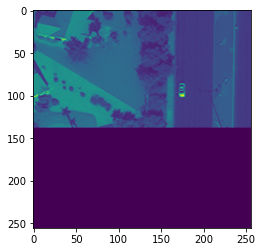

In [76]:
plt.imshow(tilesArr[6,0,:,:].cpu())

In [13]:
image = imread('/data/spacenet/bldg/data/validation/MUL/MUL-PanSharpen_AOI_2_Vegas_img1023.tif')
img = np.array((image[:,:,[4,2,1]]/(image[:,:,[4,2,1]].max()+1e-10)), dtype=np.float32)
img = np.array(img*255, dtype=np.uint8)
img = resize(img, (256, 256, 3))


img = img.astype('float32') / 255
img = img.transpose(2, 0, 1)
img = img.reshape(1,3,256,256)
img = torch.from_numpy(img)
img = img.cuda()
print(type(img))

<class 'torch.Tensor'>


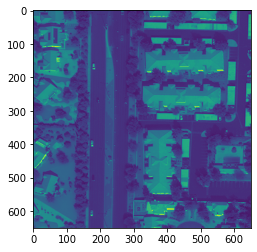

In [77]:
plt.imshow(image[:,:,0])

In [78]:
with torch.no_grad():
    output = model(tilesArr)
    #output = model(img)
    output = torch.sigmoid(output).cpu().numpy()

In [79]:
output.shape

(9, 1, 256, 256)

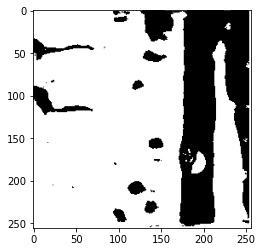

In [86]:
plt.imshow(output[0,0,:,:], cmap = 'gray')

In [81]:
torch.cuda.empty_cache()

In [82]:
def assemble_pred(predArr, corners, image, network_size):
    
    pred_image = np.zeros((image.shape[0], image.shape[1]))
    pred_image[:,:] = np.nan #NaN so we only average the overlap
    corn_idx = 0
    for pred in predArr:
        print(pred.shape)
        cornerSet = corners[corn_idx]
        topY = cornerSet[0,0]
        topX = cornerSet[0,1]
        botY = cornerSet[1,0]
        botX = cornerSet[1,1]
        tile_shape = cornerSet[2]

        img_tile = pred_image[topY:botY, topX:botX] #Tile from our total prediction image
        
        flat_img_tile = np.ndarray.flatten(img_tile) 

        pred = pred[0, 0:tile_shape[0], 0:tile_shape[1]]

        flat_pred_tile = np.ndarray.flatten(pred)
    
        new_img_tile = list(map(lambda x, y: y if np.isnan(x) else (x+y)/2, flat_img_tile, flat_pred_tile)) #Average the predictions if x isn't NaN

        new_img_tile = np.asarray(new_img_tile).reshape(tile_shape)
    
        pred_image[topY:botY, topX:botX] = new_img_tile
            
        corn_idx += 1  
    return pred_image

In [83]:
final = assemble_pred(output, corners, image, network_size)

(1, 256, 256)
(1, 256, 256)
(1, 256, 256)
(1, 256, 256)
(1, 256, 256)
(1, 256, 256)
(1, 256, 256)
(1, 256, 256)
(1, 256, 256)


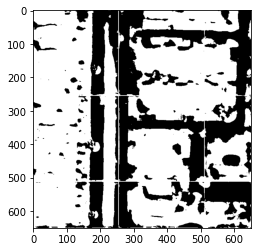

In [84]:
plt.imshow(final, cmap = 'gray')